# Imports

In [ ]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random

def pass_arg(Xx, nsim, tr_size):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #     K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)


    # import pickle

    # def save_obj(obj, name):
    #     with open(name, 'wb') as f:
    #         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    
    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

    # Making sure dimensionless bond length is less than 1
    def bond(bl):
        return tf.add(K.relu(tf.negative(bl)), K.relu(bl-1.0))

    # Making sure final porosity is less than initial
    def poros(poroi, porof):
        return K.relu(tf.negative(porof)) + K.relu(porof-poroi)

    def strength1(bl, porof, nlayer=6):
        sigma01, sigma02, C1s = 6, 31, 21
        sigma_long = sigma01*(K.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
        n = K.shape(sigma_long)[0]  
        sorted_strength, sortedIndices = tf.math.top_k(sigma_long, n, True)
        sorted_bl = K.gather(bl, sortedIndices)
        sorted_porof = K.gather(porof, sortedIndices)
        argg = tf.argsort(sorted_bl,axis=-1,direction='DESCENDING',stable=False,name=None)
        sorted_bl_corr = K.gather(sorted_bl, argg)
        return sorted_bl_corr-sorted_bl


    def strength2(bl, porof, nlayer=6):
        sigma01, sigma02, C1s = 6, 31, 21
        sigma_long = sigma01*(K.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
        n = K.shape(sigma_long)[0]  
        sorted_strength, sortedIndices = tf.math.top_k(sigma_long, n, True)
        sorted_bl = K.gather(bl, sortedIndices)
        n = K.cast(n, tf.float32)
        rel = K.relu(sorted_bl[1:]-sorted_bl[0:-1])
        num_vio = K.cast(tf.math.count_nonzero(rel), tf.float32)
        return num_vio/n


    def phy_loss_mean(params):
        # useful for cross-checking training
        loss1, loss2, loss3, loss4, lam1, lam2, lam3, lam4 = params
        def loss(y_true,y_pred):
    #         return lam1*K.mean(K.relu(loss1)) + lam2*K.mean(K.relu(loss2)) + lam2*K.mean(K.relu(loss3))
            return lam1*K.mean(K.relu(loss1)) + lam2*K.mean(K.relu(loss2)) + lam3*K.mean(K.relu(loss3)) + lam4*loss4
        return loss

    #function to calculate the combined loss = sum of rmse and phy based loss
    def combined_loss(params):
        loss1, loss2, loss3, loss4, lam1, lam2, lam3, lam4 = params
        def loss(y_true,y_pred):
    #         return mean_squared_error(y_true, y_pred) + lam1 * K.mean(K.relu(loss1)) + lam2 * K.mean(K.relu(loss2)) + lam2 * K.mean(K.relu(loss3))
            return mean_squared_error(y_true, y_pred) + lam1 * K.mean(K.relu(loss1)) + lam2 * K.mean(K.relu(loss2)) + lam3*K.mean(K.relu(loss3)) + lam4 * loss4
        return loss

    def PIML_pre(optimizer_name, optimizer_val, drop_frac, hybrid, iteration, n_layers, n_nodes, tr_size, lamda, reg, samp):

    #     fix_seeds(ss)

        # Hyper-parameters of the training process
    #     batch_size = tr_size
        batch_size = 2
        num_epochs = 600
        val_frac = 0.2
        patience_val = 50

        # Initializing results filename
        exp_name = optimizer_name + '_drop' + str(drop_frac) + '_hybrid' + str(hybrid) +  '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_lamda' + str(lamda) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '_model.h5' # storing the trained model

        if reg==True and samp==25:
            results_name = results_dir + exp_name + '_results_25_regularizer.dat' # storing the results of the model
        elif reg==False and samp==25:
            results_name = results_dir + exp_name + '_results_25.dat' # storing the results of the model
        elif reg==True and samp==1519:
            results_name = results_dir + exp_name + '_results_1519_regularizer.dat' # storing the results of the model
        elif reg==False and samp==1519:
            results_name = results_dir + exp_name + '_results_1519.dat' # storing the results of the model

        # Load labeled data
        data = np.loadtxt('../data/labeled_data.dat')
        x_label = data[:, :-3] # -2 because we do not need porosity predictions
        x_labeled = np.hstack((x_label[:,:2],x_label[:,-2:]))
        y_labeled = data[:, -3:-1] # dimensionless bond length and porosity measurements
        if samp==25:
            data = np.loadtxt('../data/unlabeled_data_BK_constw_v2_25.dat')
            x_unlabeled = data[:, :]
        elif samp==1519:
            data = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
            x_unlabeled = data[:, :]

        x_unlabeled1 = x_unlabeled[:1303, :]
        x_unlabeled2 = x_unlabeled[-6:, :]
        x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))

        # initial porosity
        init_poro = x_unlabeled[:, -1]
        x_unlabeled = np.hstack((x_unlabeled[:,:2],x_unlabeled[:,-3:-1]))

        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
        x_labeled = scaler.fit_transform(x_labeled)
        x_unlabeled = scaler.fit_transform(x_unlabeled)

        # train and test data
        trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]  
        testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]

        if hybrid == 0:
            # Removing the last column from x_unlabeled (corresponding to Y_PHY)
            x_unlabeled = x_unlabeled[:,:-1]

        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                if reg:
                    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.001, l2=.001)))
                else:
                    model.add(Dense(n_nodes, activation='relu'))
            model.add(Dropout(rate=drop_frac))
        model.add(Dense(2, activation='linear'))

        # physics-based regularization
        uinp_sc = K.constant(value=x_unlabeled) # unlabeled input data
        lam1 = K.constant(value=lamda[0]) # regularization hyper-parameter
        lam2 = K.constant(value=lamda[1]) # regularization hyper-parameter
        lam3 = K.constant(value=lamda[2]) # regularization hyper-parameter
        lam4 = K.constant(value=lamda[3]) # regularization hyper-parameter
        predictions = model(uinp_sc) # model output at depth i
        phyloss1 = bond(predictions[:,0]) # physics loss 1
        phyloss2 = poros(init_poro, predictions[:,1]) # physics loss 1
        phyloss3 = strength1(predictions[:,0], predictions[:,1])
        phyloss4 = strength2(predictions[:,0], predictions[:,1])
        totloss = combined_loss([phyloss1, phyloss2, phyloss3, phyloss4, lam1, lam2, lam3, lam4])
        phyloss = phy_loss_mean([phyloss1, phyloss2, phyloss3, phyloss4, lam1, lam2, lam3, lam4])


        model.compile(loss=totloss,
                      optimizer=optimizer_val,
                      metrics=[phyloss, root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val, verbose=1)

    #     print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=0,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])
    

    
        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)

        samples = []
        for i in range(int(nsim)):
            print("simulation num:",i)
            predictions = model.predict(Xx)
            predictions = predictions[:,1]
            samples.append(predictions[:,np.newaxis])
        return np.array(samples)



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 1
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_frac = 0 # Fraction of nodes to be dropped out
        hybrid = 1 # Whether YPhy is used as another feature in the NN model or not
        n_layers = 2 # Number of hidden layers
        n_nodes = 10 # Number of nodes per hidden layer

        #set lamda
        lamda = [0.3, 0.15, 0.008, 0] # Physics-based regularization constant  

        tr_size = int(tr_size)

        # use regularizer
        reg = True

        # sample size used
        samp = 1519
    #     samp = 25

        # total number of runs
        iter_range = np.arange(1)
        
        # iterating through all possible params
        for iteration in iter_range:
            pred = PIML_pre(optimizer_name, optimizer_val, drop_frac, hybrid, 
                            iteration, n_layers, n_nodes, tr_size, lamda, reg, samp)
            

    return np.squeeze(pred)

# Functions

In [3]:
# Main Function
if __name__ == '__main__':
    
    fix_seeds(1)
    # List of optimizers to choose from    
    optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
    optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]
    
    # selecting the optimizer
    optimizer_num = 1
    optimizer_name = optimizer_names[optimizer_num]
    optimizer_val = optimizer_vals[optimizer_num]
    
    # Selecting Other Hyper-parameters
    drop_rate = 0 # Fraction of nodes to be dropped out
    n_layers = 2 # Number of hidden layers
    n_nodes = 10 # Number of nodes per hidden layer

    # Iterating over different training fractions and splitting indices for train-test splits
#     trsize_range = [1500,20,15,10,5]
#     trsize_range = [24]
#     trsize_range = [1303]
    trsize_range = [1308]
    
    iter_range = np.arange(1) # range of iteration numbers for random initialization of NN parameters
    tr_size = trsize_range[0]
    
    # iterating through all possible params
    for iteration in iter_range:
        results, result_file = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                        iteration, n_layers, n_nodes, tr_size)

Instructions for updating:
Colocations handled automatically by placer.
Running...Adadelta
Instructions for updating:
Use tf.cast instead.
iter: 0 nL: 2 nN: 10 trsize: 1308 TestRMSE: 0.35894423723220825 PhyLoss: 0.0 



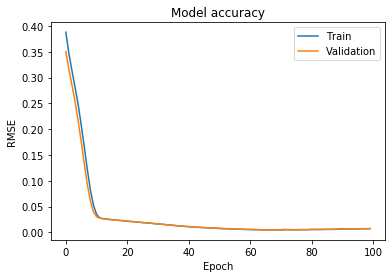

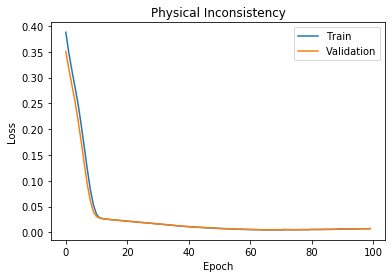

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('Model accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(train_loss_Phy)
plt.plot(val_loss_Phy)
plt.title('Physical Inconsistency')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()